In [93]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from scipy.optimize import least_squares


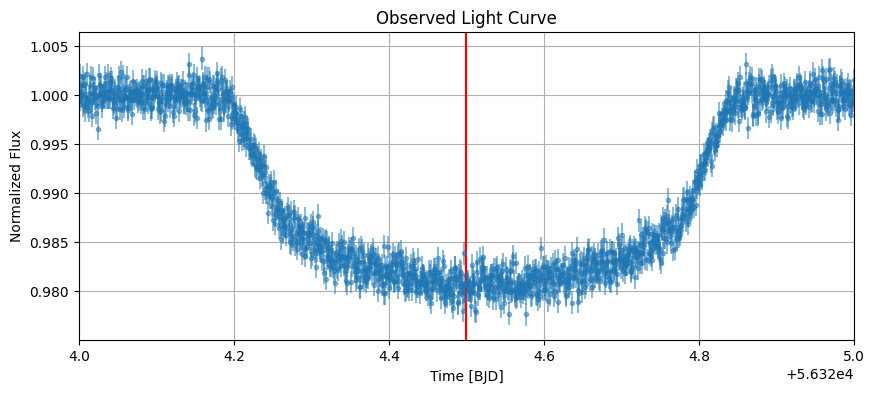

In [94]:
# Load your data: time, observed flux, and flux uncertainties
data = np.loadtxt('/pscratch/sd/e/emmayu/kipping_exomoons/KIC-3239945/photometry/planet1/AVG_SAP.dat')
time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]


# Quick sanity plot
plt.figure(figsize=(10, 4))
plt.errorbar(time, flux, yerr=flux_err, fmt='.', alpha=0.5)
plt.title("Observed Light Curve")
plt.xlabel("Time [BJD]")
plt.ylabel("Normalized Flux")
plt.xlim(56324, 56325)  # Zoom here
plt.axvline(56324.5, color='r')
plt.axvline(56324.5, color='r')


plt.grid(True)
plt.show()



## Define Model Flux Generator

In [157]:
def planet_lightcurve(t, RpRs, rho_star, b, P, tau, q1, q2):
    'tau', 'P', 'RpRs', 'b', 'rho_star', 'q1', 'q2'
    """
    Generate a planet-only transit light curve assuming strict Keplerian orbit.
    
    Parameters:
    - t: time array (BJD - 2400000)
    - RpRs: planet/star radius ratio
    - rho_star: stellar density (kg/m^3)
    - b: impact parameter
    - P: orbital period (days)
    - tau: mid-transit time (BJD - 2400000)
    - q1, q2: limb-darkening parameters (Kipping's q1, q2)
    
    Returns:
    - flux: normalized transit light curve
    """

    # Constants
    G = 6.67430e-11  # m^3/kg/s^2
    Rsun = 6.957e8    # m
    day_sec = 86400

    # Convert rho_star from g/cm^3 to kg/m^3
    rho_star_si = rho_star
    
    # Calculate semi-major axis in stellar radii using stellar density and P (Kepler's 3rd law)
    a_Rs = ((G * rho_star_si * (P * day_sec)**2) / (3 * np.pi))**(1/3)
    # Inclination (degrees) from impact parameter
    cos_i = b / a_Rs
    cos_i = np.clip(cos_i, -1, 1)
    inc = np.degrees(np.arccos(cos_i))

    # Convert Kipping q1, q2 to quadratic limb darkening coefficients u1, u2
    sqrt_q1 = np.sqrt(q1)
    u1 = 2 * sqrt_q1 * q2
    u2 = sqrt_q1 * (1 - 2 * q2)

    # Setup batman parameters
    params = batman.TransitParams()
    params.t0 = tau
    params.per = P
    params.rp = RpRs
    params.a = a_Rs
    params.inc = inc
    params.ecc = 0
    params.w = 90
    params.limb_dark = "quadratic"
    params.u = [u1, u2]

    print(f"Params: RpRs={RpRs}, a/R*={a_Rs:.2f}, inc={inc:.2f}, t0={tau}, P={P}")

    model = batman.TransitModel(params, t, supersample_factor=30, exp_time=29.4/60/24)
    flux = model.light_curve(params)
    return flux

In [148]:
'''
def lightcurve_ttv(time, transit_times, period, rp, a, inc, q1, q2):
    """
    Builds a light curve with separate t0 for each transit.

    transit_times: list or array of τi (per-transit midpoints)
    """
    model_flux = np.ones_like(time)

    for t0 in transit_times:
        params = batman.TransitParams()
        params.t0 = t0
        params.per = period
        params.rp = rp
        params.a = a
        params.inc = inc
        params.ecc = 0.0
        params.w = 90.0
        params.limb_dark = "quadratic"
        params.u = [q1, q2]

        m = batman.TransitModel(params, time, supersample_factor=30, exp_time=29.4/60/24)
        model_flux *= m.light_curve(params)  # combine multiplicatively
    return model_flux
'''

'\ndef lightcurve_ttv(time, transit_times, period, rp, a, inc, q1, q2):\n    """\n    Builds a light curve with separate t0 for each transit.\n\n    transit_times: list or array of τi (per-transit midpoints)\n    """\n    model_flux = np.ones_like(time)\n\n    for t0 in transit_times:\n        params = batman.TransitParams()\n        params.t0 = t0\n        params.per = period\n        params.rp = rp\n        params.a = a\n        params.inc = inc\n        params.ecc = 0.0\n        params.w = 90.0\n        params.limb_dark = "quadratic"\n        params.u = [q1, q2]\n\n        m = batman.TransitModel(params, time, supersample_factor=30, exp_time=29.4/60/24)\n        model_flux *= m.light_curve(params)  # combine multiplicatively\n    return model_flux\n'

In [149]:
def moon_planet_lightcurve(t, 
                           RpRs, rho_star, b, P, tau, q1, q2,
                           PS, aSP_RP, RSP, MSP, phiS, cos_iS, OmegaS):
    """
    Generate a combined planet+moon light curve using Kipping parameters.
    
    Parameters:
    - t: time array (BJD - 2400000)
    - RpRs: planet/star radius ratio
    - rho_star: stellar density (kg/m^3)
    - b: impact parameter (planet)
    - P: planet orbital period (days)
    - tau: planet mid-transit time (BJD - 2400000)
    - q1, q2: limb-darkening coefficients (Kipping's q1, q2)
    
    Moon parameters:
    - PS: satellite orbital period around planet (days)
    - aSP_RP: satellite semi-major axis in units of planet radius
    - RSP: satellite radius ratio (satellite radius / planet radius)
    - MSP: satellite mass ratio (unused in this function, relevant for TTV/TDV)
    - phiS: moon orbital phase at planet inferior conjunction [0-1]
    - cos_iS: cosine of satellite inclination
    - OmegaS: longitude of ascending node of satellite (radians or degrees, unused here)
    
    Returns:
    - flux_combined: normalized combined transit light curve of planet and moon
    """

    # Constants
    G = 6.67430e-11  # m^3/kg/s^2
    Msun = 1.9885e30  # kg
    Rsun = 6.957e8    # m
    day_sec = 86400   # seconds in a day

    # Calculate a/R* from stellar density and planet period using Kepler's 3rd law
    # a/R* = [(G * rho_star * P^2) / (3 * pi)]^(1/3)
    a_Rs = ((G * rho_star * (P * day_sec)**2) / (3 * np.pi))**(1/3) / Rsun

    # Inclination (degrees) of planet orbit from impact parameter
    cos_i = b / a_Rs
    cos_i = np.clip(cos_i, -1, 1)
    inc = np.degrees(np.arccos(cos_i))

    # Convert Kipping q1, q2 to quadratic limb darkening coefficients u1, u2
    sqrt_q1 = np.sqrt(q1)
    u1 = 2 * sqrt_q1 * q2
    u2 = sqrt_q1 * (1 - 2 * q2)

    # --- Planet transit parameters ---
    planet_params = batman.TransitParams()
    planet_params.t0 = tau
    planet_params.per = P
    planet_params.rp = RpRs
    planet_params.a = a_Rs
    planet_params.inc = inc
    planet_params.ecc = 0
    planet_params.w = 90
    planet_params.limb_dark = "quadratic"
    planet_params.u = [u1, u2]

    planet_model = batman.TransitModel(planet_params, t, supersample_factor=30, exp_time=29.4/60/24)
    flux_planet = planet_model.light_curve(planet_params)

    # --- Moon transit parameters ---
    # Calculate moon's orbital inclination in degrees
    inc_moon = np.degrees(np.arccos(np.clip(cos_iS, -1, 1)))

    # Calculate moon mid-transit time offset from planet mid-transit time:
    # Note: Kipping defines phiS as orbital phase of satellite at planet inferior conjunction
    # Moon period PS is satellite period around planet
    moon_offset = PS * (phiS - 0.5)  # centered on planet mid-transit time
    moon_t0 = tau + moon_offset

    moon_params = batman.TransitParams()
    moon_params.t0 = moon_t0
    moon_params.per = P  # Moon orbits the star with same period as planet
    moon_params.rp = RpRs * RSP  # moon/star radius ratio = (planet/star) * (moon/planet)
    moon_params.a = a_Rs
    moon_params.inc = inc_moon
    moon_params.ecc = 0
    moon_params.w = 90
    moon_params.limb_dark = "quadratic"
    moon_params.u = [u1, u2]

    moon_model = batman.TransitModel(moon_params, t, supersample_factor=30, exp_time=29.4/60/24)
    flux_moon = moon_model.light_curve(moon_params)

    # Combined flux: multiply planet and moon transits (approximation)
    flux_combined = flux_planet * flux_moon

    return flux_combined

In [150]:
def compute_chi_squared(model_flux, obs_flux, flux_err):
    return np.sum(((obs_flux - model_flux) / flux_err) ** 2)


## Define Optimizer

In [151]:
planet_param_names = ['RpRs', 'rho_star', 'b', 'P', 'tau', 'q1', 'q2']
moon_param_names = ['PS', 'aSP_RP', 'RSP', 'MSP', 'phiS', 'cos_iS', 'OmegaS']


In [152]:
def pack_params(params_dict, keys):
    return np.array([params_dict[k] for k in keys])

def unpack_params(param_array, keys):
    return dict(zip(keys, param_array))


In [153]:
def residuals_planet_only(param_array, t, flux, flux_err):
    params = unpack_params(param_array, planet_param_names)
    model_flux = planet_lightcurve(t, **params)
    return (model_flux - flux) / flux_err

def residuals_planet_moon(param_array, t, flux, flux_err):
    # Split into planet and moon parts
    planet_part = param_array[:len(planet_param_names)]
    moon_part = param_array[len(planet_param_names):]

    planet_params = unpack_params(planet_part, planet_param_names)
    moon_params = unpack_params(moon_part, moon_param_names)

    all_params = {**planet_params, **moon_params}
    model_flux = moon_planet_lightcurve(t, **all_params)
    

    return (model_flux - flux) / flux_err


In [154]:
# Assumes time, obs_flux, flux_err are defined
planet_params = {
    'RpRs': 0.124107,     # Rp/R*
    'rho_star': 2720.77,  # stellar density
    'b': 0.274943,        # impact parameter
    'P': 1071.23,         # orbital period [days]
    'tau': 55253.3,       # mid-transit time [BJD - 2400000]
    'q1': 0.428801,       # limb darkening param 1
    'q2': 0.483676        # limb darkening param 2
}
moon_params = {
    'PS': 0.630702,       # moon orbital period [days]
    'aSP_RP': 8.52847,    # moon-planet distance (in planet radii)
    'RSP': 0.114167,      # moon/planet radius ratio
    'MSP': 0.00018904,    # moon/planet mass ratio
    'phiS': 0.548778,     # moon orbital phase at planet inferior conjunction [0-1]
    'cos_iS': np.clip(2.92778, -1, 1),    # cosine of moon inclination angle
    'OmegaS': -1.57812    # longitude of ascending node (degrees)
}

In [155]:
# Initial guesses
planet_init = pack_params(planet_params, planet_param_names)
moon_init = pack_params(moon_params, moon_param_names)
both_init = np.concatenate([planet_init, moon_init])

# Example bounds (adjust as needed)
planet_bounds = (
    [0, 1000, 0, 1000, 55000, 0, 0],  # lower bounds
    [1, 5000, 1, 2000, 56000, 1, 1]   # upper bounds
)

moon_bounds = (
    [0.1, 1.0, 0.0, 0.0, 0.0, -1.0, -np.pi],  # Lower bounds: PS, aSP_RP, Rsp, Msp, phiS, cos_iS, OmegaS
    [2.0, 20.0, 0.5, 0.01, 1.0, 1.0, np.pi]   # Upper bounds
)

both_bounds = (np.concatenate([planet_bounds[0], moon_bounds[0]]),
               np.concatenate([planet_bounds[1], moon_bounds[1]]))
'''
't0': 55253.28659,
    'period': 1071.23285,
    'rp': 0.12434,
    'a': 442.75,
    'inc': 89.966,
    'q1': 0.44107,
    'q2': 0.48971
}
moon_params = {
    "rp": 0.12434,
    "t0_offset": -0.1
}

'''


'\n\'t0\': 55253.28659,\n    \'period\': 1071.23285,\n    \'rp\': 0.12434,\n    \'a\': 442.75,\n    \'inc\': 89.966,\n    \'q1\': 0.44107,\n    \'q2\': 0.48971\n}\nmoon_params = {\n    "rp": 0.12434,\n    "t0_offset": -0.1\n}\n\n'

In [158]:
from scipy.optimize import least_squares

res_planet = least_squares(
    residuals_planet_only,
    planet_init,
    bounds=planet_bounds,
    args=(time, flux, flux_err),
    method='trf',
    verbose=2
)


Params: RpRs=0.124107, a/R*=548.54, inc=89.97, t0=55253.3, P=1071.23
Params: RpRs=0.12410701490116119, a/R*=548.54, inc=89.97, t0=55253.3, P=1071.23
Params: RpRs=0.124107, a/R*=548.54, inc=89.97, t0=55253.3, P=1071.23
Params: RpRs=0.124107, a/R*=548.54, inc=89.97, t0=55253.3, P=1071.23
Params: RpRs=0.124107, a/R*=548.54, inc=89.97, t0=55253.3, P=1071.2300159625709
Params: RpRs=0.124107, a/R*=548.54, inc=89.97, t0=55253.30082333833, P=1071.23
Params: RpRs=0.124107, a/R*=548.54, inc=89.97, t0=55253.3, P=1071.23
Params: RpRs=0.124107, a/R*=548.54, inc=89.97, t0=55253.3, P=1071.23
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.2570e+03                                    2.11e+07    
Params: RpRs=0.12437100273475075, a/R*=545.32, inc=89.97, t0=55253.28674258069, P=1071.2327303350762
Params: RpRs=0.12437101763591195, a/R*=545.32, inc=89.97, t0=55253.28674258069, P=1071.2327303350762
Params: RpRs=0.12437100273475075

In [134]:
print("Initial values:")
print("both_init =", both_init)

print("\nLower bounds:")
print("both_bounds[0] =", both_bounds[0])

print("\nUpper bounds:")
print("both_bounds[1] =", both_bounds[1])

res_moon = least_squares(
    residuals_planet_moon,
    both_init,
    bounds=both_bounds,
    args=(time, flux, flux_err),
    method='trf',
    verbose=2
)


Initial values:
both_init = [ 1.24107e-01  2.72077e+03  2.74943e-01  1.07123e+03  5.52533e+04
  4.28801e-01  4.83676e-01  6.30702e-01  8.52847e+00  1.14167e-01
  1.89040e-04  5.48778e-01  1.00000e+00 -1.57812e+00]

Lower bounds:
both_bounds[0] = [ 0.00000000e+00  1.00000000e+03  0.00000000e+00  1.00000000e+03
  5.50000000e+04  0.00000000e+00  0.00000000e+00  1.00000000e-01
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.00000000e+00 -3.14159265e+00]

Upper bounds:
both_bounds[1] = [1.00000000e+00 5.00000000e+03 1.00000000e+00 2.00000000e+03
 5.60000000e+04 1.00000000e+00 1.00000000e+00 2.00000000e+00
 2.00000000e+01 5.00000000e-01 1.00000000e-02 1.00000000e+00
 1.00000000e+00 3.14159265e+00]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1178e+05                                    3.45e+04    
       1              2         1.1131e+05      4.71e+02       1.03e-01       2.67e+04    
     

In [159]:
def compute_chi2(res):
    chi2 = np.sum(res.fun**2)
    dof = len(flux) - len(res.x)
    return chi2, chi2 / dof

chi2_planet, redchi2_planet = compute_chi2(res_planet)
chi2_moon, redchi2_moon = compute_chi2(res_moon)

print("Planet-only reduced chi^2:", redchi2_planet)
print("Planet+Moon reduced chi^2:", redchi2_moon)


Planet-only reduced chi^2: 1.002895897521305
Planet+Moon reduced chi^2: 22.920394926562807


Params: RpRs=0.1935385252245938, a/R*=548.57, inc=89.97, t0=55253.30075211954, P=1071.4383337804697


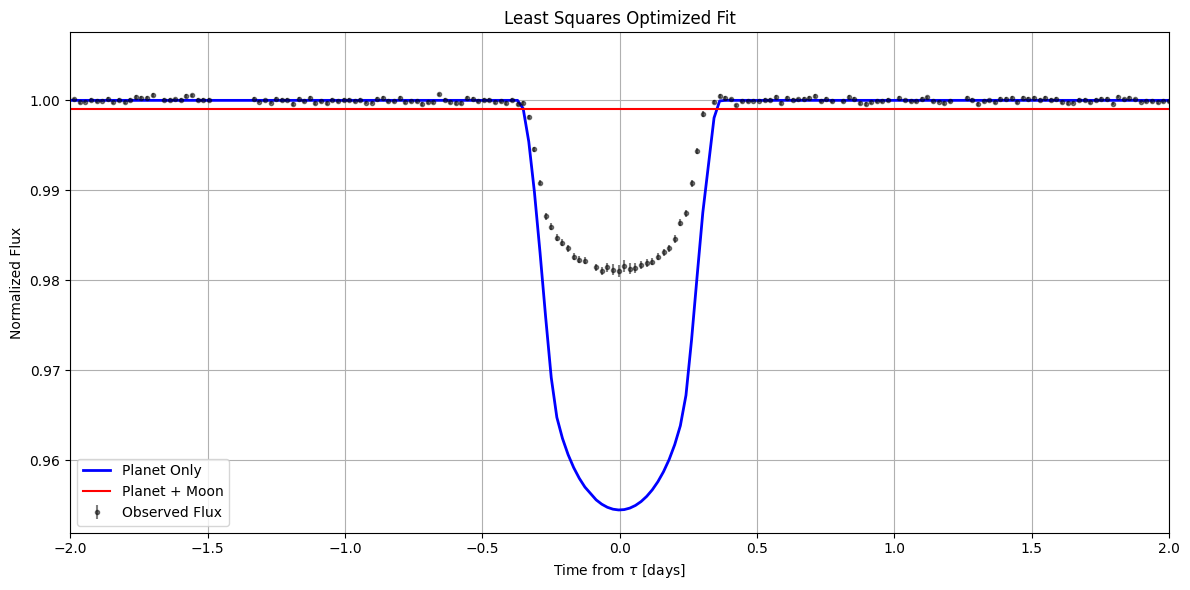

In [160]:
# Unpack optimized parameters
fitted_planet_params = unpack_params(res_moon.x[:len(planet_param_names)], planet_param_names)
fitted_moon_params = unpack_params(res_moon.x[len(planet_param_names):], moon_param_names)

# Center time on best-fit tau
tau_fit = fitted_planet_params['tau']
time_centered = time - tau_fit

# Sort data for clean plotting
sorted_idx = np.argsort(time_centered)
time_sorted = time_centered[sorted_idx]
flux_sorted = flux[sorted_idx]
flux_err_sorted = flux_err[sorted_idx]

# Compute model fluxes on original (absolute) time axis
t_absolute = time_sorted + tau_fit

# Model fluxes
model_flux_planet = planet_lightcurve(t_absolute, **fitted_planet_params)
model_flux_moon = moon_planet_lightcurve(
    t_absolute,
    **fitted_planet_params,
    **fitted_moon_params
)

# Plotting
plt.figure(figsize=(12, 6))

plt.errorbar(time_sorted, flux_sorted, yerr=flux_err_sorted,
             fmt='.', color='black', alpha=0.5, label="Observed Flux")

plt.plot(time_sorted, model_flux_planet, label="Planet Only", lw=2, color='blue')
plt.plot(time_sorted, model_flux_moon, label="Planet + Moon", lw=1.5, color='red')

plt.xlim(-2, 2)   # adjust as needed
#plt.ylim(0.98, 1.002)

plt.xlabel("Time from $\\tau$ [days]")
plt.ylabel("Normalized Flux")
plt.title("Least Squares Optimized Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Example

In [60]:
# Model 1: Planet only
model_flux_planet = lightcurve_planet(time, **planet_params)
chi2_planet = compute_chi_squared(model_flux_planet, flux, flux_err)

# Model 3: Planet + Moon
model_flux_moon = lightcurve_moon_simple(planet_params, moon_params, time)
chi2_moon = compute_chi_squared(model_flux_moon, flux, flux_err)

# Print results
print("Chi² values:")
print(f"  Planet only:     {chi2_planet:.2f}")
#print(f"  Planet + TTV:    {chi2_ttv:.2f}")
print(f"  Planet + Moon:   {chi2_moon:.2f}")

Chi² values:
  Planet only:     39312.48
  Planet + Moon:   448513.52


In [ ]:
dof = len(flux) - len(res.x)
39312.48/dof


In [61]:
'''
# Model 2: TTV
model_flux_ttv = lightcurve_ttv(time, ttv_transit_times, planet_params['period'],
                                 planet_params['rp'], planet_params['a'],
                                 planet_params['inc'], planet_params['q1'], planet_params['q2'])
chi2_ttv = compute_chi_squared(model_flux_ttv, obs_flux, flux_err)
'''


"\n# Model 2: TTV\nmodel_flux_ttv = lightcurve_ttv(time, ttv_transit_times, planet_params['period'],\n                                 planet_params['rp'], planet_params['a'],\n                                 planet_params['inc'], planet_params['q1'], planet_params['q2'])\nchi2_ttv = compute_chi_squared(model_flux_ttv, obs_flux, flux_err)\n"

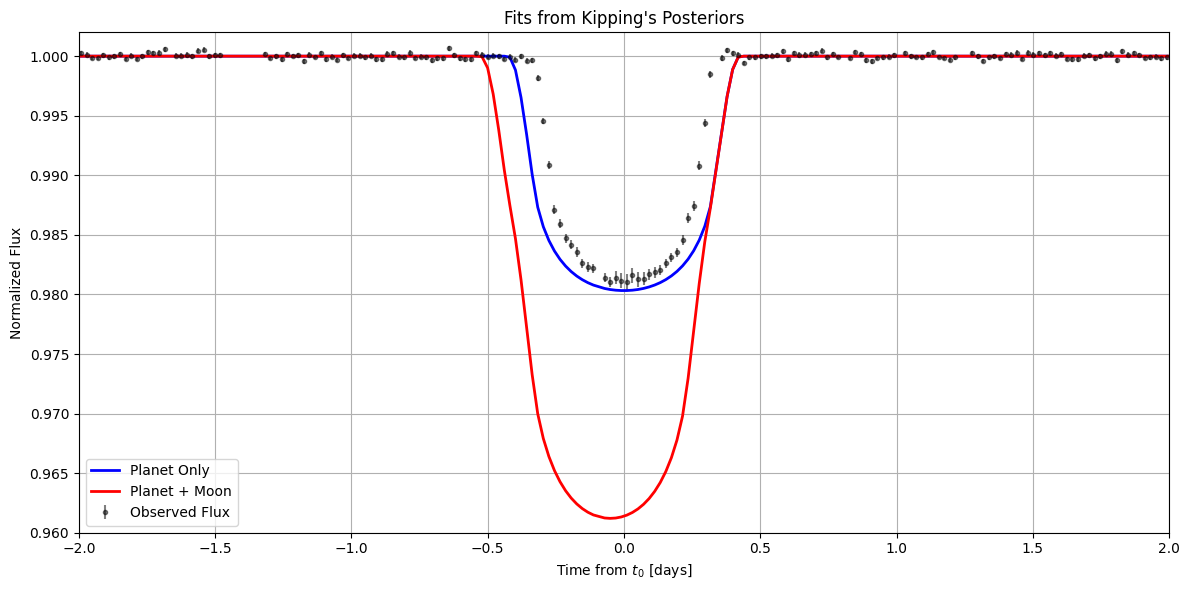

In [65]:
# Recenter time around the planet mid-transit t0
t0 = planet_params['t0']
time_centered = time - t0

# Sort for plotting
sorted_idx = np.argsort(time_centered)
time_sorted = time_centered[sorted_idx]
flux_sorted = flux[sorted_idx]
flux_err_sorted = flux_err[sorted_idx]

# Re-evaluate models on centered time (convert back to absolute BJD for batman)
t_absolute = time_sorted + t0

model_flux_planet = lightcurve_planet(t_absolute, **planet_params)
model_flux_moon = lightcurve_moon_simple(planet_params, moon_params, t_absolute)

# Plot everything
plt.figure(figsize=(12, 6))

plt.errorbar(time_sorted, flux_sorted, yerr=flux_err_sorted, fmt='.', color='black', alpha=0.5, label="Observed Flux")

plt.plot(time_sorted, model_flux_planet, label="Planet Only", lw=2, color='blue')
plt.plot(time_sorted, model_flux_moon, label="Planet + Moon", lw=2, color='red')

plt.xlim(-2, 2)  # Adjust this if your transit is more/less spread out
plt.ylim(0.96, 1.002)

plt.xlabel("Time from $t_0$ [days]")
plt.ylabel("Normalized Flux")
plt.title("Fits from Kipping's Posteriors")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()